In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/advancev11/molnn_advance_v1.1.h5
/kaggle/input/molnn-basic-weights/molnn_basic.h5
/kaggle/input/molecular-properties/dataset.csv
/kaggle/input/molnnadd/molnn_advance_v1.1-2.h5
/kaggle/input/molnn-advance/molnn_advance_v1.h5


In [2]:
experiments = []

In [3]:
df = pd.read_csv('/kaggle/input/molecular-properties/dataset.csv')
df.head()

,Unnamed: 0,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,mulliken_charge_0,mulliken_charge_1,atom_0,...,YXmag_1,ZXmag_1,XYmag_1,YYmag_1,ZYmag_1,XZmag_1,YZmag_1,ZZmag_1,atom1_0,atom1_1
0,0,0,dsgdb9nsd_000001,1,0,1,84.8076,0.133921,-0.535689,0,...,0.0000,-0.0001,0.0000,195.3171,0.0007,-0.0001,0.0007,195.3169,0,0
1,1,4,dsgdb9nsd_000001,2,0,1,84.8074,0.133922,-0.535689,0,...,0.0000,-0.0001,0.0000,195.3171,0.0007,-0.0001,0.0007,195.3169,0,0
2,2,7,dsgdb9nsd_000001,3,0,1,84.8093,0.133923,-0.535689,0,...,0.0000,-0.0001,0.0000,195.3171,0.0007,-0.0001,0.0007,195.3169,0,0
3,3,9,dsgdb9nsd_000001,4,0,1,84.8095,0.133923,-0.535689,0,...,0.0000,-0.0001,0.0000,195.3171,0.0007,-0.0001,0.0007,195.3169,0,0
4,4,1,dsgdb9nsd_000001,1,2,0,-11.2570,0.133921,0.133922,0,...,1.2173,-4.1474,1.2173,28.9036,-1.6036,-4.1476,-1.6036,33.8967,1,0


In [4]:
y = df.scalar_coupling_constant
X = df.iloc[:,3:].drop('scalar_coupling_constant',axis=1)
print('Traget_Variable: {}'.format(y.name))
print('Independent Variables: {}'.format(X.columns))

Traget_Variable: scalar_coupling_constant
Independent Variables: Index(['atom_index_0', 'atom_index_1', 'type', 'mulliken_charge_0',
       'mulliken_charge_1', 'atom_0', 'x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1',
       'potential_energy', 'fc', 'sd', 'pso', 'dso', 'XXmag_0', 'YXmag_0',
       'ZXmag_0', 'XYmag_0', 'YYmag_0', 'ZYmag_0', 'XZmag_0', 'YZmag_0',
       'ZZmag_0', 'XXmag_1', 'YXmag_1', 'ZXmag_1', 'XYmag_1', 'YYmag_1',
       'ZYmag_1', 'XZmag_1', 'YZmag_1', 'ZZmag_1', 'atom1_0', 'atom1_1'],
      dtype='object')


In [5]:
geometric_features = ['atom_index_0','atom_index_1','type','atom_0','atom1_0','atom1_1']


In [6]:
# Splitting the Data into Train Test, Test Set and Validation Set
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.2, random_state=234, shuffle = True)
X_test,X_val,y_test,y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state =214, shuffle = True)
print('X_train: {}'.format(X_train.shape))
print('y_train: {}'.format(y_train.shape))
print('X_test: {}'.format(X_test.shape))
print('y_test: {}'.format(y_test.shape))
print('X_val: {}'.format(X_val.shape))
print('y_val: {}'.format(y_val.shape))

X_train: (3727260, 37)
y_train: (3727260,)
X_test: (465908, 37)
y_test: (465908,)
X_val: (465908, 37)
y_val: (465908,)


In [7]:
# Deleting unecessary DataFrames
del df
del X
del y

# Neural Network Training, Testing & Optimisation

In [8]:
import keras
from keras.models import Model,load_model,save_model
from keras.optimizers import Adam
from keras.losses import mean_squared_error
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.layers import Input, Dense, Dropout
from keras import backend as K

Using TensorFlow backend.


## 1. Essential Functions for Training

This Section consists some essentials function which are used for training and testing purpose throughout this notebook

In [9]:
def neural_network_creator(inputs = 0, outputs = 1, hidden_layers = 4, hidden_layer_size = [64,128,64,32],rate=1.0):
    """
    This function creates a Dense Neural network on the basis of provided specifications
    
    Parameters
    ------------------------------------------------------------------------------------
    inputs: Size of the Input layer in form of total features
    outputs: Size of Output Layer
    hidden_layers: No. of hidden layers in the Neural Network
    hidden_layer_size: A list consists of size of corresponding hidden neural layer
    ------------------------------------------------------------------------------------
    
    ==========================================
    returns a Neural Network Model
    ==========================================
    """
    inputs = Input(shape=(inputs,), name='input_layer')
    for i in range(hidden_layers):
        if i == 0:
            x = Dense(hidden_layer_size[i], activation='relu',name='dense_layer_{}'.format(i))(inputs)
        else: 
            x = Dropout(rate,name='Dropout_layer_{}'.format(i))(x)
            x = Dense(hidden_layer_size[i], activation='relu',name='dense_layer_{}'.format(i))(x)
    
    output = Dense(1,activation='linear',name='output_layer')(x)
    model = Model(inputs=inputs,outputs=output)
    return model

In [10]:
def r_square_metric(y_true,y_pred):
    SS_res =  K.sum(K.square(y_true-y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return ( 1 - SS_res/(SS_tot + K.epsilon()))

In [11]:
def create_callback(model_name):
    model_checkpoint = ModelCheckpoint(model_name,monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
    early = EarlyStopping(monitor="val_loss", mode="min", patience=10,verbose=1)
    reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_delta=0.0001, cooldown=5, min_lr=0.00001,verbose=1)
    return [reduceLR, early, model_checkpoint]


In [12]:
from sklearn.metrics import r2_score as r2
metric_list = [r_square_metric,keras.metrics.mean_squared_error]
def train_network(modeldict,lr=0.01,batch_size=128,callbacks = None,metrics = metric_list,
                  training_data=[X_train,y_train],test_data=(X_test,y_test),model=None,epoch=40):
    """
    This function either accepts the pre specified model or make the new and return the tuple containing
    history object and hyper-parameters info after training and testing the neural network simultaneously.
    
    Parameters
    ----------------------------------------------------------------------------------------------------
    modeldict: Dictionary containing the architecture specification of neural network
    lr: Learning rate to be used for training NN (int type)
    batch_size: Batch Size to be used
    callbacks: List of Callabacks to be implemented using training
    metrics: List of losses to be used while training
    training_data: List of feature vector and target vector to be used for training
    test_data: List of feature vector and target vectr to be used for testing
    model: Instance of a model, if it is None then the model is created on the basis of modeldict
    ----------------------------------------------------------------------------------------------------
    
    ====================================================================================================
    returns a tuple of training history, hyper-parameters
    ====================================================================================================
    """
    adam = Adam(lr=lr)
    if model == None:
        model = neural_network_creator(modeldict['inputs'],modeldict['outputs'],modeldict['hidden_layers'],
                                  modeldict['hidden_layer_size'],modeldict['dropout_rate'])
        model.compile(optimizer=adam,loss='mean_squared_error',metrics=metrics)
    else:
        model.compile(optimizer=adam,loss='mean_squared_error',metrics=metrics)
        
    history = model.fit(x=training_data[0],y=training_data[1],batch_size=batch_size,
                       verbose=1,epochs=epoch,callbacks = callbacks,validation_data=test_data)
    parameters = {'LayerNum':modeldict['hidden_layers'],'learning_rate':lr,'optimizer':'adam',
                  'batch_size':batch_size,'metrices':metrics,'layer_sizes':str(modeldict['hidden_layer_size']),'dropout_rate':modeldict['dropout_rate'] }
    
    return (history,parameters)

In [13]:
# MolNet Basic
callbacks_list = create_callback('molnn_basic.h5')
model_dict_b = {'inputs':37, 'outputs':1, 'hidden_layers': 3, 'hidden_layer_size':[64, 128, 37],'dropout_rate':1.0}
stats = train_network(modeldict=model_dict_b,lr=0.01,callbacks=callbacks_list,
                      training_data=[X_train.values,y_train.values],test_data=[X_test.values,y_test.values],model=None,epoch=80)

Train on 3727260 samples, validate on 465908 samples
Epoch 1/80
3727260/3727260 [==============================] - 124s 33us/step - loss: 1.2827 - r_square_metric: 0.9989 - mean_squared_error: 1.2827 - val_loss: 0.0080 - val_r_square_metric: 1.0000 - val_mean_squared_error: 0.0080

Epoch 00001: val_loss improved from inf to 0.00802, saving model to molnn_basic.h5
Epoch 2/80
3727260/3727260 [==============================] - 119s 32us/step - loss: 0.0849 - r_square_metric: 1.0000 - mean_squared_error: 0.0849 - val_loss: 0.0042 - val_r_square_metric: 1.0000 - val_mean_squared_error: 0.0042

Epoch 00002: val_loss improved from 0.00802 to 0.00421, saving model to molnn_basic.h5
Epoch 3/80
3727260/3727260 [==============================] - 114s 31us/step - loss: 0.0402 - r_square_metric: 1.0000 - mean_squared_error: 0.0402 - val_loss: 1.8510e-04 - val_r_square_metric: 1.0000 - val_mean_squared_error: 1.8510e-04

Epoch 00009: val_loss improved from 0.00022 to 0.00019, saving model to molnn_b

In [14]:
def model_performance_visualization(hisob,x1,x2,title='...'):
    fig,ax = plt.subplots(1,1,figsize=(6,6))
    ax.plot(hisob.history[x1],label=x1)
    ax.plot(hisob.history[x2],label=x2)
    ax.set_title(title,fontweight="bold")
    ax.legend()

In [15]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score
def regression_metrics(y_pred,y_true,parameters,experiments):
    print('R-square: {}'.format(r2(y_true,y_pred)))
    parameters['r-square'] = r2(y_true,y_pred)
    print('MSE: {}'.format(mse(y_true,y_pred)))
    parameters['MSE'] = mse(y_true,y_pred)
    if parameters not in experiments:
        experiments.append(parameters)

In [16]:
import matplotlib as mpl
def plot_prediction_truevalue(y_pred,y_true,model_name):
    mpl.rcParams['agg.path.chunksize'] = 10000
    fig,ax = plt.subplots(1,1)
    ax.scatter(y_pred,y_true,marker='o')
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('True Values')
    ax.set_title(model_name)
    plt.show()

In [17]:
def test_on_validation(model_path,title,model_dict,stats,X_val):
    
    model_b = neural_network_creator(model_dict['inputs'],model_dict['outputs'],model_dict['hidden_layers'],
                                      model_dict['hidden_layer_size'],model_dict['dropout_rate'])
    model_b.load_weights(model_path)

    y_val_pred = model_b.predict(X_val)
    regression_metrics(y_val_pred, y_val, stats[1],experiments)

    plot_prediction_truevalue(y_val_pred,y_val,title)
    
    return model_b

In [18]:
def transfer_learning(model=None,input_size=0,model_dict=None,is_trainable=False,freeze_layer_start = None,prior=False):
    model_dict['inputs'] = input_size
    i = freeze_layer_start
    print(model_dict)
    n_model = neural_network_creator(inputs=model_dict['inputs'],outputs= model_dict['outputs'],hidden_layers= model_dict['hidden_layers'],
                                      hidden_layer_size = model_dict['hidden_layer_size'],rate = model_dict['dropout_rate'])

    # New Model Making and Transfer Learning
    for n_layer, layer in zip(n_model.layers[2:], model.layers[2:]):
        n_layer.set_weights(layer.get_weights())
    
    if prior != True:
        for layer in n_model.layers[i:-1]:
            layer.trainable = is_trainable
    else:
        for layer in n_model.layers[:i]:
            layer.trainable = is_trainable

    print(n_model.summary())
    
    return n_model,model_dict

# <hr>

## MolNet Basic & Advance

In [19]:
# MolNet Advance
callbacks_list = create_callback('molnn_advance.h5')
model_dict_ad = {'inputs':37, 'outputs':1, 'hidden_layers': 6, 'hidden_layer_size':[256, 256, 128, 128, 64, 64],'dropout_rate':0.5}
stats1 = train_network(modeldict=model_dict_ad,lr=0.001,callbacks=callbacks_list,
                      training_data=[X_train.values,y_train.values],test_data=[X_test.values,y_test.values],model=None,epoch=40)

Train on 3727260 samples, validate on 465908 samples
Epoch 1/40
3727260/3727260 [==============================] - 159s 43us/step - loss: 54.5224 - r_square_metric: 0.9552 - mean_squared_error: 54.5222 - val_loss: 141.6472 - val_r_square_metric: 0.8842 - val_mean_squared_error: 141.6472

Epoch 00001: val_loss improved from inf to 141.64717, saving model to molnn_advance.h5
Epoch 2/40
3727260/3727260 [==============================] - 158s 42us/step - loss: 19.9132 - r_square_metric: 0.9836 - mean_squared_error: 19.9132 - val_loss: 85.9418 - val_r_square_metric: 0.9299 - val_mean_squared_error: 85.9418

Epoch 00002: val_loss improved from 141.64717 to 85.94176, saving model to molnn_advance.h5
Epoch 3/40
3727260/3727260 [==============================] - 159s 43us/step - loss: 21.7230 - r_square_metric: 0.9822 - mean_squared_error: 21.7230 - val_loss: 94.7242 - val_r_square_metric: 0.9234 - val_mean_squared_error: 94.7241

Epoch 00003: val_loss did not improve from 85.94176
Epoch 4/40
3

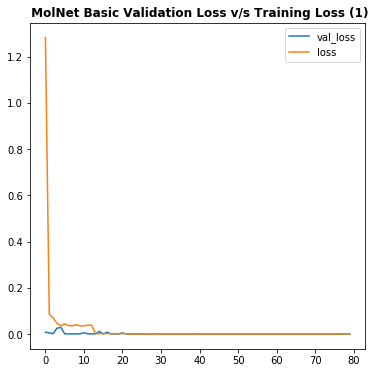

In [20]:
model_performance_visualization(stats[0],'val_loss','loss',' MolNet Basic Validation Loss v/s Training Loss (1)')

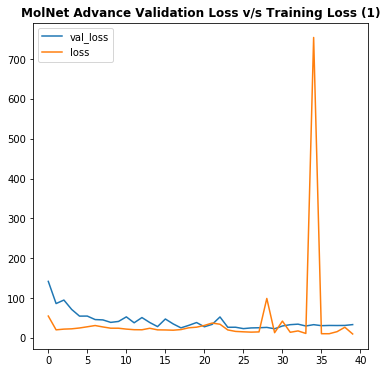

In [21]:
model_performance_visualization(stats1[0],'val_loss','loss','MolNet Advance Validation Loss v/s Training Loss (1)')

In [22]:
model_dict_b = {'inputs':37, 'outputs':1, 'hidden_layers': 3, 'hidden_layer_size':[64, 128, 37],'dropout_rate':1.0}
model_b = test_on_validation(model_path='molnn_basic.h5', title='MolNN Basic with Dropout(1.0)',model_dict = model_dict_b,stats = stats)

TypeError: test_on_validation() missing 1 required positional argument: 'X_val'

## --------------------------------------------------------------------------------------------------------------

R-square: 0.9815994645560764
MSE: 22.410606878046327


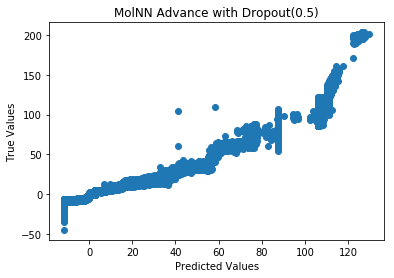

In [23]:
# MolNet Advance
test_on_validation(model_path='molnn_advance.h5', title='MolNN Advance with Dropout(0.5)',model_dict = model_dict_ad, stats=stats1, X_val = X_val.values)

<hr>

## 2. Transfer Learning and Feature Selection

### MolNet Basic V1

In [24]:
# MolNet Basic V1
callbacks_list = create_callback('molnn_basic_v1.h5')
n_model,model_dict_v1 = transfer_learning(model=model_b, input_size=6, model_dict=model_dict_b, freeze_layer_start = 5,prior = False)
stats_bv1 = train_network(modeldict=model_dict_b,lr=0.01,callbacks=callbacks_list,
                          training_data=[X_train[geometric_features].values,y_train.values],test_data=[X_test[geometric_features].values,y_test.values],model=n_model,epoch=40)

NameError: name 'model_b' is not defined

for i in n_model.layers[5:-1]:
    print(i.name)

In [25]:
model_performance_visualization(stats_bv1[0],'val_loss','loss',' MolNet Basic V1 Validation Loss v/s Training Loss (1)')

NameError: name 'stats_bv1' is not defined

In [26]:
test_on_validation(model_path='molnn_basic_v1.h5', title='MolNN Basic V1 with Dropout(1.0)',model_dict = model_dict_v1, 
                   stats = stats_bv1, X_val = X_val[geometric_features].values)

NameError: name 'model_dict_v1' is not defined

## MolNN Advance V1

This model architecture is simiral to that of MolNN Advance with the difference in dropout rate i.e. 1.0 instead of 0.5

In [27]:
# Modified Model
callbacks_list = create_callback('molnn_advance_v1.h5')
model_dict_ad['dropout_rate'] = 1.0
stats2 = train_network(modeldict=model_dict_ad,lr=0.001,callbacks=callbacks_list,
                      training_data=[X_train.values,y_train.values],test_data=[X_test.values,y_test.values],model=None,epoch=40)

Train on 3727260 samples, validate on 465908 samples
Epoch 1/40
3727260/3727260 [==============================] - 138s 37us/step - loss: 0.7084 - r_square_metric: 0.9994 - mean_squared_error: 0.7084 - val_loss: 0.0665 - val_r_square_metric: 1.0000 - val_mean_squared_error: 0.0665

Epoch 00001: val_loss improved from inf to 0.06650, saving model to molnn_advance_v1.h5
Epoch 2/40
3727260/3727260 [==============================] - 137s 37us/step - loss: 0.0636 - r_square_metric: 1.0000 - mean_squared_error: 0.0636 - val_loss: 0.0053 - val_r_square_metric: 1.0000 - val_mean_squared_error: 0.0053

Epoch 00002: val_loss improved from 0.06650 to 0.00530, saving model to molnn_advance_v1.h5
Epoch 3/40
3727260/3727260 [==============================] - 137s 37us/step - loss: 0.0363 - r_square_metric: 1.0000 - mean_squared_error: 0.0363 - val_loss: 0.0010 - val_r_square_metric: 1.0000 - val_mean_squared_error: 0.0010

Epoch 00003: val_loss improved from 0.00530 to 0.00102, saving model to molnn

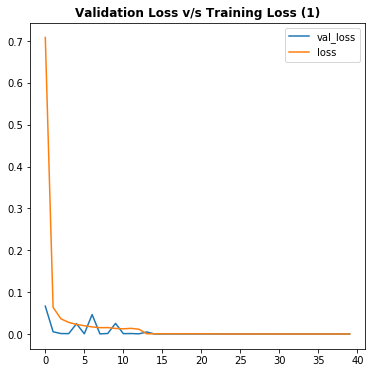

In [28]:
model_performance_visualization(stats2[0],'val_loss','loss','Validation Loss v/s Training Loss (1)')

R-square: 0.9999999987682222
MSE: 1.5002220018781118e-06


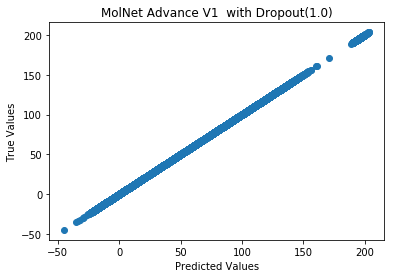

In [29]:
model_b = test_on_validation(model_path='molnn_advance_v1.h5', title='MolNet Advance V1  with Dropout(1.0)',
                             model_dict = model_dict_ad, stats=stats2, X_val=X_val)

In [30]:
pearson_features = ['atom_index_1','YYmag_1','XXmag_1','ZZmag_1','atom1_0','sd','mulliken_charge_1','dso','type','atom_index_0','atom1_1','atom_0']

In [31]:
# New Model with different input neurons by fine tuning Upper layers
callbacks_list = create_callback('molnn_advance_v1.1.h5')
n_model,model_dict_adv1 = transfer_learning(model=model_b, input_size=len(pearson_features), model_dict=model_dict_ad, freeze_layer_start = -4,is_trainable=False)
stats_adv1 = train_network(modeldict=model_dict_adv1,training_data=[X_train[pearson_features].values,y_train.values], epoch=40,lr=0.01,
                       test_data=[X_test[pearson_features].values,y_test.values],model=n_model,batch_size=64,callbacks = callbacks_list)

{'inputs': 12, 'outputs': 1, 'hidden_layers': 6, 'hidden_layer_size': [256, 256, 128, 128, 64, 64], 'dropout_rate': 1.0}
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 12)                0         
_________________________________________________________________
dense_layer_0 (Dense)        (None, 256)               3328      
_________________________________________________________________
Dropout_layer_1 (Dropout)    (None, 256)               0         
_________________________________________________________________
dense_layer_1 (Dense)        (None, 256)               65792     
_________________________________________________________________
Dropout_layer_2 (Dropout)    (None, 256)               0         
_________________________________________________________________
dense_layer_2 (Dense)        (None, 128)               32896     
____

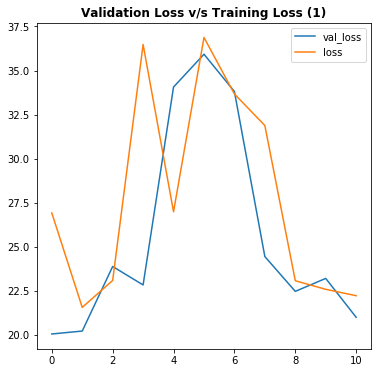

In [32]:
model_performance_visualization(stats_adv1[0],'val_loss','loss','Validation Loss v/s Training Loss (1)')

R-square: 0.984348805577459
MSE: 19.06209558109719


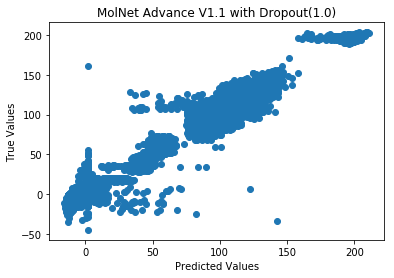

In [33]:
model_b = test_on_validation(model_path='molnn_advance_v1.1.h5', 
                             title='MolNet Advance V1.1 with Dropout(1.0)',model_dict = model_dict_adv1, stats=stats_adv1,
                             X_val = X_val[pearson_features].values)